$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [15]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=12
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global num_action
num_action=8

global obs_para
obs_para=6

global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.2**(N-i))
print(coeff)

[1.1258999068426271e-35, 5.629499534213136e-35, 2.8147497671065676e-34, 1.4073748835532837e-33, 7.036874417766418e-33, 3.5184372088832087e-32, 1.7592186044416043e-31, 8.796093022208022e-31, 4.39804651110401e-30, 2.199023255552005e-29, 1.0995116277760024e-28, 5.497558138880012e-28, 2.7487790694400056e-27, 1.374389534720003e-26, 6.871947673600013e-26, 3.4359738368000065e-25, 1.717986918400003e-24, 8.589934592000015e-24, 4.294967296000008e-23, 2.1474836480000035e-22, 1.0737418240000018e-21, 5.368709120000009e-21, 2.684354560000004e-20, 1.342177280000002e-19, 6.71088640000001e-19, 3.3554432000000048e-18, 1.6777216000000023e-17, 8.388608000000011e-17, 4.194304000000005e-16, 2.0971520000000026e-15, 1.0485760000000012e-14, 5.2428800000000056e-14, 2.6214400000000027e-13, 1.3107200000000013e-12, 6.5536000000000055e-12, 3.276800000000003e-11, 1.6384000000000013e-10, 8.192000000000005e-10, 4.096000000000002e-09, 2.0480000000000012e-08, 1.0240000000000006e-07, 5.120000000000002e-07, 2.560000000000

In [16]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [17]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(10-np.sqrt((obs[0]-target[0])**2+(obs[1]-target[1])**2)-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [18]:
global lr
lr=0.01
global eps
eps=0.05
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/2],[-1,np.pi/2],[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4],[1,-np.pi/2],[-1,-np.pi/2]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(num_action)
    else:
        result=[]
        for i in range(num_action):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(num_action):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(num_action)]
history_r=[0 for i in range(num_action)]
history_su_next=[0 for i in range(num_action)]
flags=[True for i in range(num_action)]

history_rt=[[[] for i in range(num_action)] for j in range(N+1)]
history_sut=[[[] for i in range(num_action)] for j in range(N+1)]
flags_t=[[True for i in range(num_action)] for j in range(N+1)]

# Simulation


In [19]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(num_action)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(num_action)]
    
    '''
    coeff=[]
    for i in range(N):
        coeff.append((np.random.random()-0.5)/100+0.8**(N-i))
    coeff.append(1)
    #print(coeff)
    '''
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(num_action):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(num_action):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(num_action):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:00<00:39,  2.00it/s]

observation = [-3.03916459e+00 -2.74767937e+00 -1.94778745e+00  2.66331120e-03
  3.40315590e-02  2.34945933e-02]


  2%|██                                                                                 | 2/80 [00:01<00:42,  1.84it/s]

observation = [-3.29824587e+00 -3.33242774e+00 -1.94778745e+00  2.97078031e-03
  9.51529256e-03  2.34945933e-02]


  4%|███                                                                                | 3/80 [00:01<00:43,  1.77it/s]

observation = [-2.57754978e+00 -3.38440018e+00  5.02654825e-01  3.07319008e-03
  3.17509302e-04  5.75595329e-02]


  5%|████▏                                                                              | 4/80 [00:02<00:41,  1.81it/s]

observation = [-2.08449899e+00 -2.69122565e+00 -2.13628300e+00  1.88169677e-03
  2.75914013e-03  2.14959984e-02]


  6%|█████▏                                                                             | 5/80 [00:02<00:41,  1.79it/s]

observation = [-2.25774311e+00 -2.37973439e+00 -1.00530965e+00  3.74622070e-04
  1.57719545e-03  3.48199643e-02]


  8%|██████▏                                                                            | 6/80 [00:03<00:44,  1.66it/s]

observation = [-1.17590400e+00 -1.76868723e+00  1.31946891e+00  9.96312841e-04
  5.74443832e-04  2.17624777e-03]


  9%|███████▎                                                                           | 7/80 [00:04<00:46,  1.57it/s]

observation = [-1.26496828e+00 -1.59701619e+00  1.31946891e+00  3.65686348e-04
  1.29076948e-03  2.17624777e-03]


 10%|████████▎                                                                          | 8/80 [00:04<00:48,  1.49it/s]

observation = [-1.12431774e+00 -7.55752997e-01  1.31946891e+00  3.22909646e-04
  4.27201682e-03  2.17624777e-03]


 11%|█████████▎                                                                         | 9/80 [00:05<00:50,  1.41it/s]

observation = [-9.50134382e-01 -2.90924301e-01  1.31946891e+00  9.87110765e-04
  8.17453738e-03  2.17624777e-03]


 12%|██████████▎                                                                       | 10/80 [00:06<00:51,  1.36it/s]

observation = [-0.90009498  0.21689039  1.13097336  0.00306517  0.01278231  0.00159888]


 14%|███████████▎                                                                      | 11/80 [00:07<00:53,  1.30it/s]

observation = [-0.67422997  1.1226975   1.13097336  0.00824893  0.02380133  0.00159888]


 15%|████████████▎                                                                     | 12/80 [00:08<00:54,  1.24it/s]

observation = [-4.70429377e+00  3.29123258e+00 -5.65486678e-01  1.60556571e-02
  1.10168279e-01  3.99718978e-04]


 16%|█████████████▎                                                                    | 13/80 [00:09<00:56,  1.19it/s]

observation = [ 3.62181842e-01 -7.21739589e-02  3.76991118e-01  1.10240924e-03
  1.49518906e-02  1.77652879e-04]


 18%|██████████████▎                                                                   | 14/80 [00:10<00:58,  1.13it/s]

observation = [1.10051919e+00 4.87774992e-01 3.76991118e-01 1.98621794e-03
 2.48745367e-02 1.77652879e-04]


 19%|███████████████▍                                                                  | 15/80 [00:11<01:00,  1.08it/s]

observation = [6.11221902e+00 6.16085835e-01 3.76991118e-01 5.54785696e-02
 2.95145561e-02 1.77652879e-04]


 20%|████████████████▍                                                                 | 16/80 [00:12<01:01,  1.03it/s]

observation = [5.39374416e+00 1.57905589e+00 7.53982237e-01 3.74769966e-02
 5.63960117e-02 7.10611517e-04]


 21%|█████████████████▍                                                                | 17/80 [00:13<01:03,  1.01s/it]

observation = [4.70724690e+00 3.45970982e+00 1.31946891e+00 8.90010019e-03
 1.18212797e-01 2.17624777e-03]


 22%|██████████████████▍                                                               | 18/80 [00:14<01:05,  1.06s/it]

observation = [6.07309981e+00 4.58539955e-01 3.76991118e-01 5.34866699e-02
 2.57182058e-02 1.77652879e-04]


 24%|███████████████████▍                                                              | 19/80 [00:15<01:08,  1.12s/it]

observation = [4.68144367e+00 3.57693621e+00 1.69646003e+00 4.95217370e-03
 1.07904152e-01 3.59747080e-03]


 25%|████████████████████▌                                                             | 20/80 [00:17<01:10,  1.18s/it]

observation = [5.16730075e+00 2.85806929e+00 1.88495559e+00 1.52400880e-02
 8.13338109e-02 4.44132198e-03]


 26%|█████████████████████▌                                                            | 21/80 [00:18<01:13,  1.25s/it]

observation = [4.54841393e+00 2.95799619e+00 1.69646003e+00 1.13487297e-02
 1.01656884e-01 3.59747080e-03]


 28%|██████████████████████▌                                                           | 22/80 [00:19<01:16,  1.32s/it]

observation = [4.21410214e+00 3.19857775e+00 1.13097336e+00 6.12841207e-03
 1.03503786e-01 1.59887591e-03]


 29%|███████████████████████▌                                                          | 23/80 [00:21<01:21,  1.42s/it]

observation = [4.01512622e+00 6.29679724e+00 1.50796447e+00 1.11499768e-02
 1.91045810e-01 2.84244607e-03]


 30%|████████████████████████▌                                                         | 24/80 [00:23<01:25,  1.53s/it]

observation = [2.97559229e+00 5.54721694e+00 1.88495559e+00 1.55562374e-02
 1.31797800e-01 4.44132198e-03]


 31%|█████████████████████████▋                                                        | 25/80 [00:25<01:29,  1.64s/it]

observation = [4.62221022e+00 3.07263248e+00 1.69646003e+00 8.86444398e-03
 9.25411333e-02 3.59747080e-03]


 32%|██████████████████████████▋                                                       | 26/80 [00:27<01:34,  1.75s/it]

observation = [3.53217035e+00 3.19952801e+00 1.13097336e+00 1.68341436e-03
 9.98334689e-02 1.59887591e-03]


 34%|███████████████████████████▋                                                      | 27/80 [00:29<01:40,  1.90s/it]

observation = [6.42299594e-01 6.56958865e+00 1.88495559e+00 1.05310020e-01
 1.13979751e-01 4.44132198e-03]


 35%|████████████████████████████▋                                                     | 28/80 [00:31<01:46,  2.04s/it]

observation = [1.92608488e+00 7.92999656e+00 1.50796447e+00 9.88421829e-02
 2.04250259e-01 2.84244607e-03]


 36%|█████████████████████████████▋                                                    | 29/80 [00:34<01:53,  2.22s/it]

observation = [3.22162058e+00 5.86572190e+00 9.42477796e-01 1.39806464e-02
 1.66296229e-01 1.11033050e-03]


 38%|██████████████████████████████▊                                                   | 30/80 [00:37<01:59,  2.39s/it]

observation = [3.38983988e+00 2.69140069e+00 5.65486678e-01 3.43786349e-03
 8.25720351e-02 3.99718978e-04]


 39%|███████████████████████████████▊                                                  | 31/80 [00:40<02:05,  2.57s/it]

observation = [5.53578546e+00 6.42634730e+00 7.53982237e-01 1.03908345e-04
 2.46088623e-01 7.10611517e-04]


 40%|████████████████████████████████▊                                                 | 32/80 [00:43<02:11,  2.74s/it]

observation = [5.06525855e+00 2.06799847e+00 1.31946891e+00 2.60975856e-02
 6.95222472e-02 2.17624777e-03]


 41%|█████████████████████████████████▊                                                | 33/80 [00:46<02:16,  2.91s/it]

observation = [3.42473342e+00 2.79294411e+00 1.13097336e+00 3.56281450e-03
 8.91414189e-02 1.59887591e-03]


 42%|██████████████████████████████████▊                                               | 34/80 [00:50<02:21,  3.09s/it]

observation = [3.09996146e+00 2.60949455e+00 7.53982237e-01 3.20125895e-03
 8.50887399e-02 7.10611517e-04]


 44%|███████████████████████████████████▉                                              | 35/80 [00:54<02:27,  3.27s/it]

observation = [2.14461586e+00 3.73430827e+00 7.53982237e-01 5.60815238e-03
 8.59031217e-02 7.10611517e-04]


 45%|████████████████████████████████████▉                                             | 36/80 [00:57<02:32,  3.46s/it]

observation = [3.95963552e+00 7.07061646e+00 1.13097336e+00 1.55015302e-02
 2.56270449e-01 1.59887591e-03]


 46%|█████████████████████████████████████▉                                            | 37/80 [01:02<02:38,  3.69s/it]

observation = [2.55445304e+00 6.11869852e+00 2.07345115e+00 2.91359335e-02
 1.56465485e-01 5.37399960e-03]


 48%|██████████████████████████████████████▉                                           | 38/80 [01:06<02:44,  3.92s/it]

observation = [3.46583176e+00 2.46403075e+00 1.13097336e+00 4.29685665e-03
 7.43898977e-02 1.59887591e-03]


 49%|███████████████████████████████████████▉                                          | 39/80 [01:11<02:50,  4.15s/it]

observation = [5.05978824e+00 1.01725588e+00 3.76991118e-01 3.65594115e-02
 4.01691532e-02 1.77652879e-04]


 50%|█████████████████████████████████████████                                         | 40/80 [01:16<02:55,  4.40s/it]

observation = [2.98964726e+00 4.70268609e+00 9.42477796e-01 4.83158599e-03
 1.15258682e-01 1.11033050e-03]


 51%|██████████████████████████████████████████                                        | 41/80 [01:21<03:00,  4.64s/it]

observation = [1.15904656 4.62465572 2.26194671 0.03788816 0.04073051 0.0063955 ]


 52%|███████████████████████████████████████████                                       | 42/80 [01:26<03:04,  4.86s/it]

observation = [2.17585144e+00 3.00604522e+00 7.53982237e-01 9.18282676e-04
 6.23800532e-02 7.10611517e-04]


 54%|████████████████████████████████████████████                                      | 43/80 [01:32<03:08,  5.08s/it]

observation = [1.92668493e+00 2.74110227e+00 1.50796447e+00 5.40868167e-04
 7.43144356e-02 2.84244607e-03]


 55%|█████████████████████████████████████████████                                     | 44/80 [01:38<03:12,  5.34s/it]

observation = [2.43598409e+00 2.74816103e+00 1.13097336e+00 4.68497167e-05
 7.28065651e-02 1.59887591e-03]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [01:44<03:15,  5.59s/it]

observation = [1.99175459e+00 2.49683072e+00 1.13097336e+00 1.37023025e-04
 6.34482564e-02 1.59887591e-03]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [01:51<03:22,  5.96s/it]

observation = [9.25862865e-01 6.57480146e+00 2.07345115e+00 1.17566971e-01
 5.50357883e-02 5.37399960e-03]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [01:58<03:24,  6.19s/it]

observation = [1.92870974e+00 1.66488884e+00 1.50796447e+00 1.13698525e-03
 5.16515011e-02 2.84244607e-03]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [02:04<03:24,  6.39s/it]

observation = [1.97244904e+00 1.65224909e+00 1.88495559e+00 1.26471101e-03
 5.22294307e-02 4.44132198e-03]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [02:12<03:27,  6.70s/it]

observation = [2.27776280e+00 1.95902263e+00 1.69646003e+00 1.51849627e-03
 5.97548384e-02 3.59747080e-03]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [02:20<03:36,  7.21s/it]

observation = [2.57914041 1.80323177 1.50796447 0.00447289 0.05998045 0.00284245]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [02:28<03:36,  7.46s/it]

observation = [2.04596519e+00 1.94719469e+00 1.88495559e+00 5.78715515e-04
 5.30644159e-02 4.44132198e-03]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [02:37<03:37,  7.76s/it]

observation = [2.5380802  1.86454424 1.88495559 0.00375046 0.06205396 0.00444132]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [02:45<03:37,  8.05s/it]

observation = [2.92620398 1.89543815 1.88495559 0.00510926 0.06026302 0.00444132]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [02:54<03:35,  8.28s/it]

observation = [2.76572395 1.89514482 1.69646003 0.00557461 0.07015619 0.00359747]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [03:04<03:34,  8.56s/it]

observation = [2.62327471 1.85733399 1.88495559 0.00448808 0.0640749  0.00444132]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [03:13<03:33,  8.89s/it]

observation = [1.59581608e+00 1.82343087e+00 1.88495559e+00 5.50745264e-05
 5.03731247e-02 4.44132198e-03]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [03:23<03:32,  9.22s/it]

observation = [2.57372145 1.84350183 1.88495559 0.00416678 0.06193814 0.00444132]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [03:34<03:30,  9.58s/it]

observation = [1.89164871e+00 1.61700285e+00 2.07345115e+00 1.22173804e-03
 4.84280159e-02 5.37399960e-03]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [03:44<03:29,  9.96s/it]

observation = [2.41061322 1.61513651 2.26194671 0.00455492 0.0619077  0.0063955 ]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [03:56<03:26, 10.31s/it]

observation = [0.43099793 1.68913287 2.26194671 0.00352167 0.03122554 0.0063955 ]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [04:07<03:22, 10.64s/it]

observation = [0.73997225 2.47991282 1.88495559 0.00744717 0.04480673 0.00444132]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [04:20<03:21, 11.21s/it]

observation = [9.29933971e-01 2.01751431e+00 1.88495559e+00 1.30936158e-03
 2.11493685e-02 4.44132198e-03]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [04:32<03:18, 11.70s/it]

observation = [2.46665658 1.76205993 2.26194671 0.003919   0.07079972 0.0063955 ]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [04:45<03:12, 12.04s/it]

observation = [2.39833884 1.89834221 2.07345115 0.00262597 0.05989898 0.005374  ]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [05:01<03:18, 13.21s/it]

observation = [2.01483699e+00 1.47355549e+00 2.26194671e+00 2.23556694e-03
 5.95923891e-02 6.39550365e-03]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [05:15<03:09, 13.52s/it]

observation = [2.59961223 1.86240526 2.26194671 0.00409807 0.06405254 0.0063955 ]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [05:30<03:01, 13.98s/it]

observation = [2.09931898 1.30606026 2.07345115 0.00374913 0.05383762 0.005374  ]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [05:45<02:50, 14.25s/it]

observation = [2.41716613 1.62471685 2.45044227 0.00462281 0.06239254 0.00750583]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [06:00<02:38, 14.43s/it]

observation = [2.371778   1.87652345 2.45044227 0.00270375 0.0580598  0.00750583]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [06:16<02:27, 14.72s/it]

observation = [ 1.22108061e+00  1.61631676e+00 -3.07876080e+00  1.13581753e-03
  1.08221093e-02  1.28354205e-02]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [06:32<02:16, 15.13s/it]

observation = [ 1.36056023e+00  1.59247106e+00 -3.07876080e+00  1.88872605e-03
  1.19692075e-02  1.28354205e-02]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [06:48<02:04, 15.54s/it]

observation = [ 1.45175194e+00  1.53884620e+00 -3.07876080e+00  1.91940937e-03
  1.87989931e-02  1.28354205e-02]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [07:15<02:13, 19.02s/it]

observation = [ 1.64459840e+00  1.67813511e+00 -3.07876080e+00  2.40595102e-03
  1.72672560e-02  1.28354205e-02]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [07:34<01:52, 18.79s/it]

observation = [ 2.43943393  1.67088789 -2.89026524  0.00749997  0.04118073  0.01438988]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [07:52<01:33, 18.63s/it]

observation = [2.78486980e+00 2.07934681e+00 2.45044227e+00 1.55346794e-03
 5.29809799e-02 7.50583415e-03]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [08:11<01:14, 18.70s/it]

observation = [2.19411563e+00 2.46321899e+00 7.53982237e-01 4.40874840e-05
 6.77661579e-02 7.10611517e-04]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [08:30<00:56, 18.88s/it]

observation = [ 1.84752486e+00  1.74789420e+00 -3.07876080e+00  2.67781615e-03
  2.18536246e-02  1.28354205e-02]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [08:50<00:38, 19.21s/it]

observation = [2.89928330e+00 2.13196329e+00 1.50796447e+00 4.53883888e-03
 6.99386912e-02 2.84244607e-03]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [09:10<00:19, 19.53s/it]

observation = [2.76155228e+00 2.24793376e+00 7.53982237e-01 2.93925678e-03
 7.20432477e-02 7.10611517e-04]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [09:31<00:00,  7.15s/it]

observation = [ 1.73077368e+00  1.68149979e+00 -3.07876080e+00  2.88087143e-03
  1.86065481e-02  1.28354205e-02]


# Results

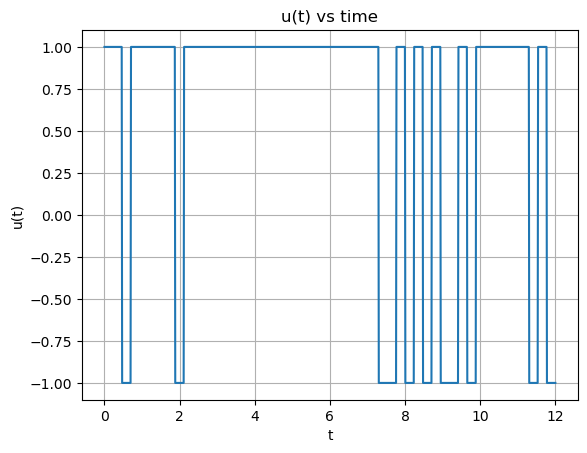

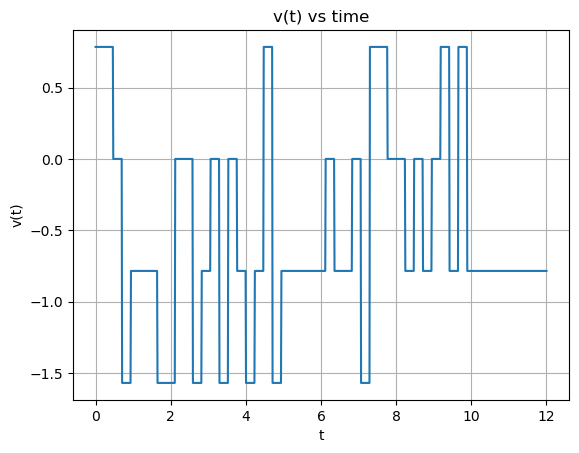

In [20]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


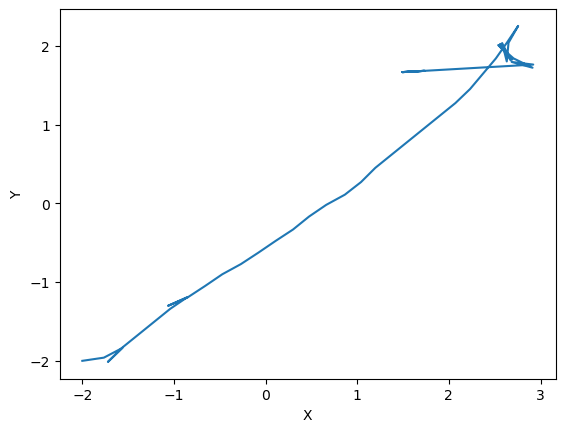

In [21]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

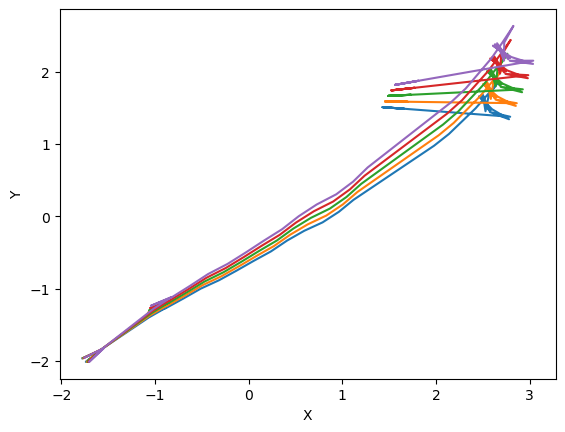

6.57017651923313


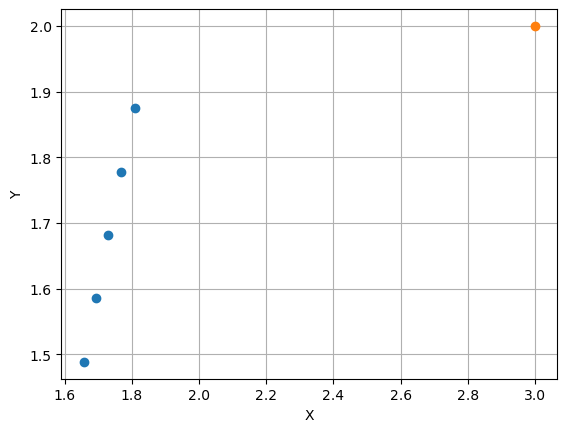

In [22]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

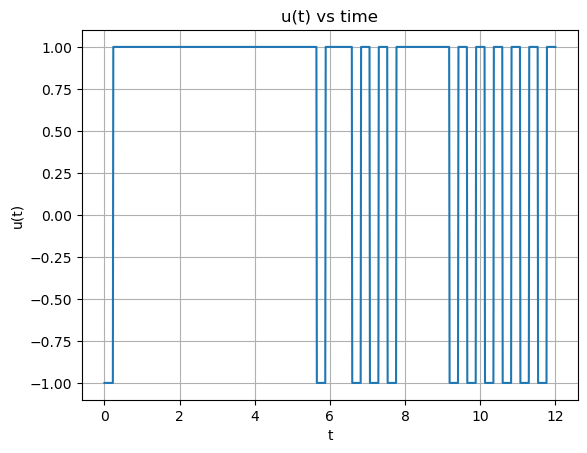

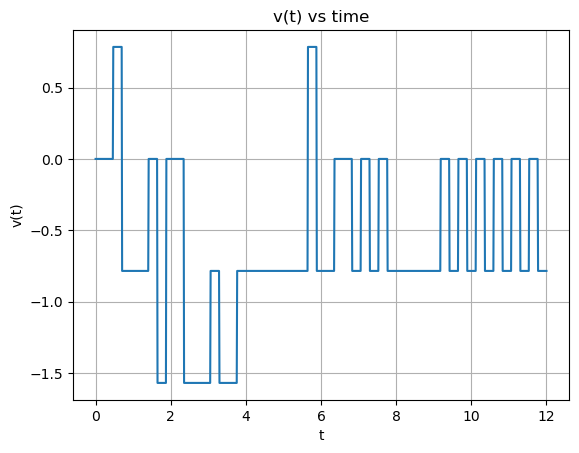

In [23]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

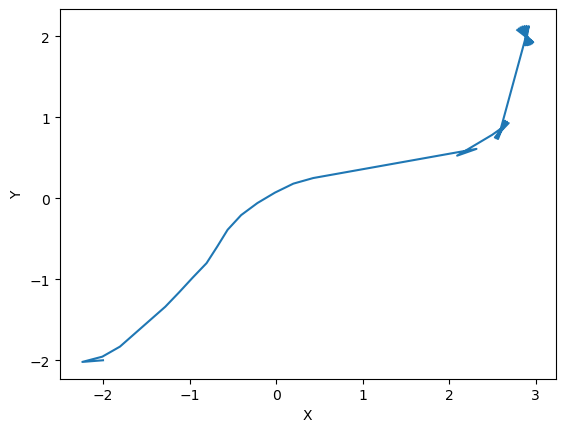

In [24]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

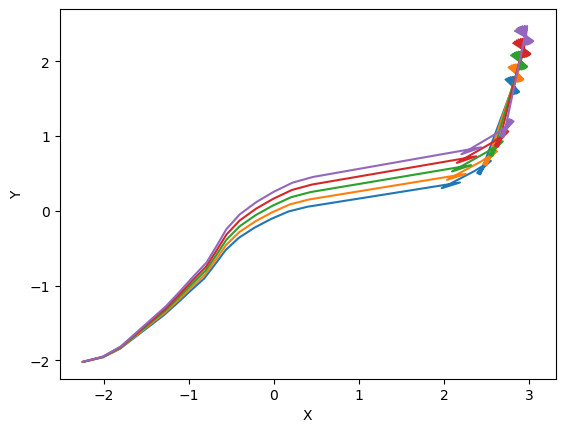

1.5898007013289472


In [25]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

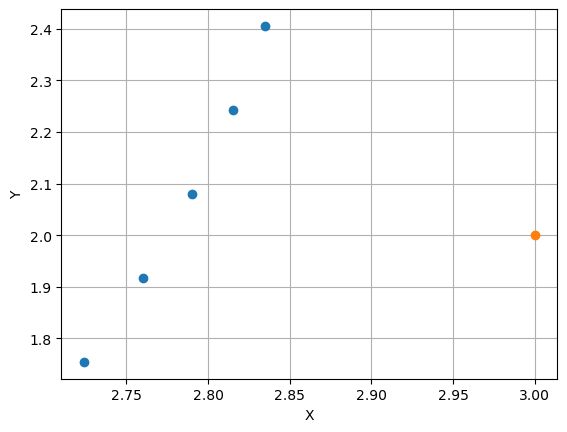

In [26]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

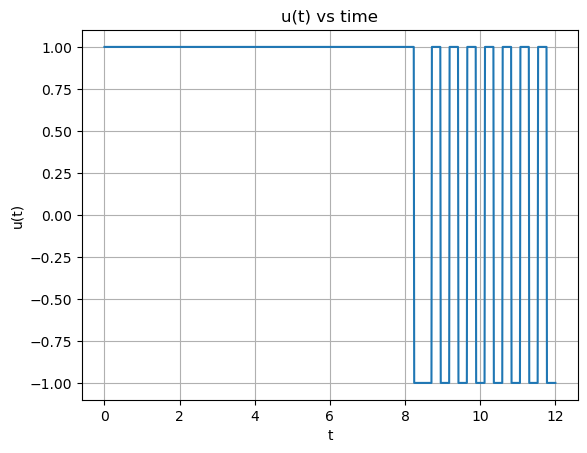

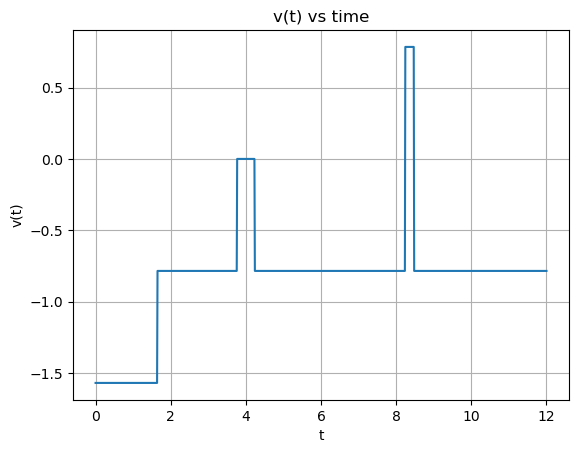

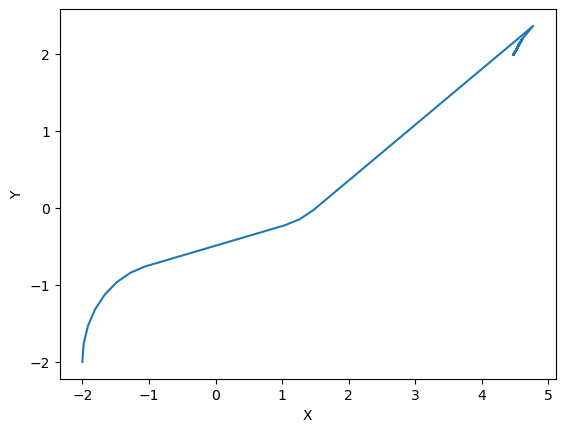

In [27]:
position=np.array([[-2,-2,np.pi/2] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

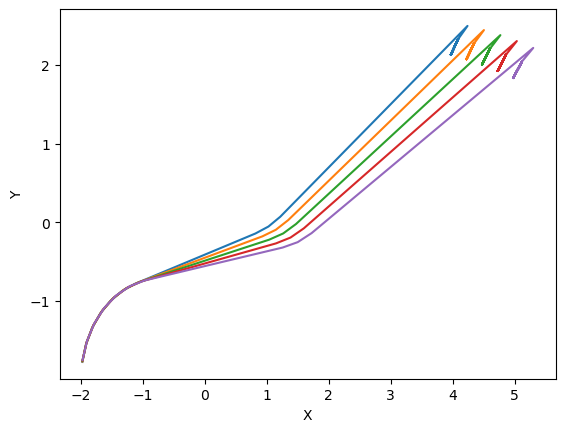

7.39942010661339


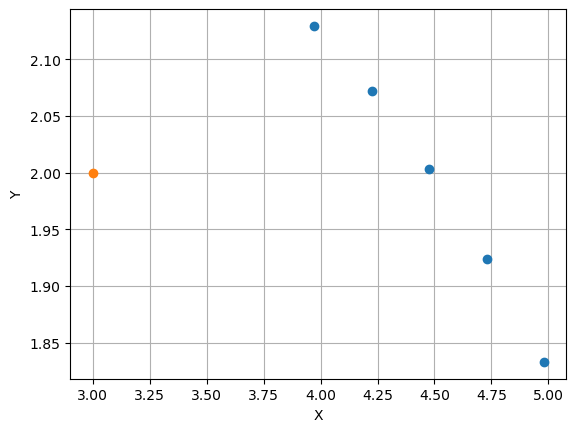

In [28]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()